In [30]:
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached grpcio-1.67.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorflow_io_gcs_filesystem-0.37.1-cp311-cp311-manylinux_

In [31]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
%matplotlib inline

2024-10-25 08:07:52.117619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729843672.140399    3641 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729843672.146752    3641 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 08:07:52.169393: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
stock_prices

NameError: name 'stock_prices' is not defined

In [33]:
data_dir = 'dataset/stocknet-dataset-master/price/raw'
stock_dataframes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        df['Stock'] = filename[:-4]
        df = df.iloc[:400]
        stock_dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
all_stocks_data = pd.concat(stock_dataframes, ignore_index=True)

scaler = MinMaxScaler()
all_stocks_data['Open_scaled'] = scaler.fit_transform(all_stocks_data[['Open']])

In [34]:
all_stocks_data

,Date,Open,High,Low,Close,Adj Close,Volume,Stock,Open_scaled
0,2012-09-04,45.299999,45.599998,45.209999,45.470001,36.115128,2778100.0,SO,0.000218
1,2012-09-05,45.590000,45.619999,45.340000,45.369999,36.035698,2713000.0,SO,0.000220
2,2012-09-06,45.660000,46.070000,45.549999,46.070000,36.591686,4217200.0,SO,0.000220
3,2012-09-07,46.099998,46.150002,45.830002,45.910000,36.464603,2810800.0,SO,0.000222
4,2012-09-10,46.000000,46.009998,45.680000,45.689999,36.289860,2141200.0,SO,0.000222
...,...,...,...,...,...,...,...,...,...
35092,2014-04-02,94.879997,94.919998,93.279999,94.040001,84.829010,2097700.0,NEE,0.000481
35093,2014-04-03,94.680000,95.250000,94.440002,94.599998,85.334160,1283400.0,NEE,0.000480
35094,2014-04-04,94.870003,95.910004,94.599998,95.010002,85.704010,1779800.0,NEE,0.000481
35095,2014-04-07,94.790001,95.279999,93.879997,93.900002,84.702705,2096200.0,NEE,0.000481


In [35]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Create sequences for each stock
X, y = [], []
for stock_name, group in all_stocks_data.groupby('Stock'):
    stock_X, stock_y = create_sequences(group['Open_scaled'].values)
    X.append(stock_X)
    y.append(stock_y)

# Concatenate the arrays
X = np.concatenate(X)
y = np.concatenate(y)

In [36]:
regressor = Sequential()

regressor.add(Input(shape=(X.shape[1], 1)))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

W0000 00:00:1729843677.571325    3641 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [37]:
regressor.compile(optimizer='adam', loss='mse')
regressor.fit(X, y, batch_size=128, epochs=10, validation_split=0.25)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0017 - val_loss: 1.2131e-06
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 1.5888e-04 - val_loss: 1.4861e-06
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 1.4859e-04 - val_loss: 2.5103e-06
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 1.3021e-04 - val_loss: 4.0974e-06
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 1.1306e-04 - val_loss: 5.6500e-09
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 1.2611e-04 - val_loss: 1.1429e-06
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 9.1988e-05 - val_loss: 1.2469e-06
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 1.4484e-04 - val_loss: 7.1848e-07
Epoch 9/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 9.7456e-05 - val_loss: 8.6867e-08
Epoch 10/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 1.0251e-04 - val_loss: 3.1243e-07
Epoch 11/100
175/175 ━━━━━━━━━━━━

In [38]:
dataset_test = pd.read_csv("dataset/stocknet-dataset-master/price/raw/ABB.csv")
actual_stock_price = dataset_test.iloc[:,1:2].values

In [39]:
dataset_total = dataset_test['Open']
inputs = dataset_total[400:].values

inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []

for i in range(60,460):
    X_test.append(inputs[i-60:i, 0])
X_test = scaler.fit_transform(X_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [40]:
scaler = MinMaxScaler()
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = predicted_stock_price[:, -1]  # Shape becomes (1000,)
scaled = scaler.fit_transform(actual_stock_price)
# Reshape back to 2D to apply inverse transform (MinMaxScaler expects 2D)
predicted_stock_price = predicted_stock_price.reshape(-1, 1)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

prediction = np.concatenate((actual_stock_price[0:400], predicted_stock_price))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


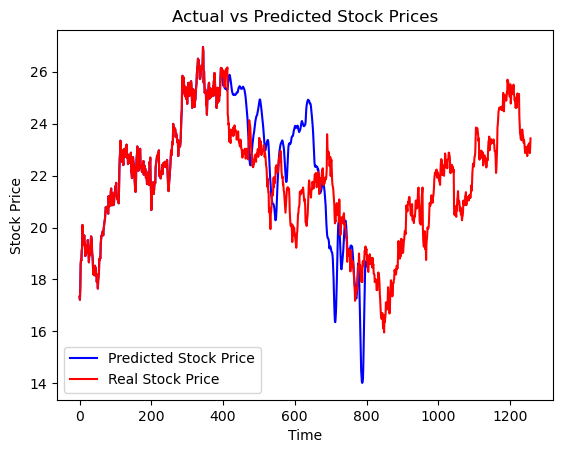

In [41]:
plt.plot(prediction, color='blue', label='Predicted Stock Price') 
plt.plot(actual_stock_price, color='red', label='Real Stock Price')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [42]:
X_test = X_test[:200]
X_test.shape

(200, 60, 1)

In [44]:
scaled = scaler.fit_transform(actual_stock_price)
pred = X_test[-1].reshape((X_test[-1].shape[0]))
for i in range(400):
    data = pred.reshape((1, pred.shape[0], 1))
    predicted_stock_price = regressor.predict(data)
    predicted_stock_price = predicted_stock_price[:, -1]
    pred = np.append(pred, predicted_stock_price)
    data = data.reshape(-1, 1)
    predicted_stock_price = predicted_stock_price.reshape(-1,1)
    print(f"Yesterday: {scaler.inverse_transform(data)[-1]} Today: {scaler.inverse_transform(predicted_stock_price)}, Tru")
    
pred = np.array(pred)
pred = pred.reshape(-1, 1)
pred = scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Yesterday: [23.95028322] Today: [[23.814434]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Yesterday: [23.814433] Today: [[23.836624]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Yesterday: [23.83662365] Today: [[23.852104]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Yesterday: [23.85210522] Today: [[23.86264]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Yesterday: [23.86264047] Today: [[23.873093]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Yesterday: [23.87309384] Today: [[23.88398]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Yesterday: [23.88398086] Today: [[23.895823]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Yesterday: [23.89582229] Today: [[23.908432]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Yesterday: [23.90843079] Today: [[23.92165]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Yesterday: [23.9216498] Today: [[23.935278]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Yesterday: [23.93527757] Today: [[23.94918]], Tru
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [45]:
prediction = np.concatenate((actual_stock_price[:600], pred[60:460]))

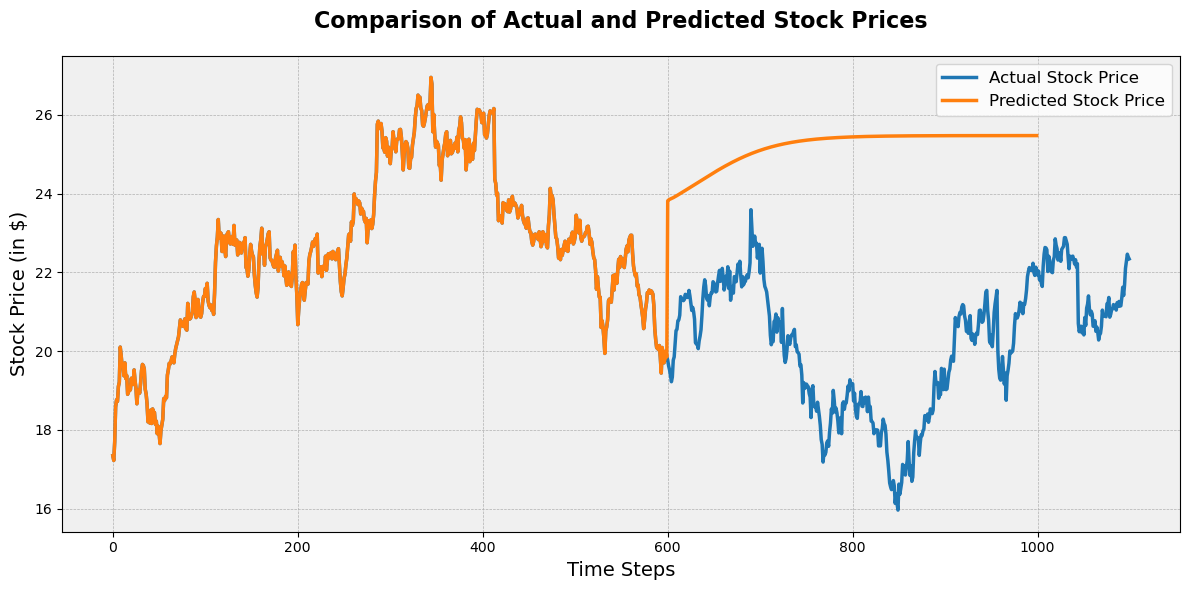

In [46]:
plt.figure(figsize=(12, 6))  # Set a larger figure size for better readability

# Plot actual stock prices with a smooth line and custom color
plt.plot(actual_stock_price[0:1100], color='#1f77b4', label='Actual Stock Price', linewidth=2.5)

# Plot predicted stock prices with a dashed line and another custom color
plt.plot(prediction[0:1100], color='#ff7f0e', linestyle='-', label='Predicted Stock Price', linewidth=2.5)

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add title with a clearer and more informative description
plt.title("Comparison of Actual and Predicted Stock Prices", fontsize=16, fontweight='bold', pad=20)

# Customize x and y labels with larger fonts
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Stock Price (in $)", fontsize=14)

# Add a legend with larger text
plt.legend(fontsize=12)

# Add a light grey background for the plot area
plt.gca().set_facecolor('#f0f0f0')

# Display the plot
plt.tight_layout()
plt.show()


In [47]:
pred[0], scaler.inverse_transform(X_test[-1][-1].reshape(-1,1))

(array([19.22762836]), array([[23.95028322]]))

In [48]:
dataset_test = pd.read_csv("dataset/stocknet-dataset-master/price/raw/AAPL.csv")
test_aapl_price = dataset_test.iloc[400:460,1:2].values
test_appl_y = dataset_test.iloc[460,1:2].values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(test_aapl_price)

In [49]:
test_aapl_price = np.array(test_aapl_price)
test_aapl_price = np.reshape(test_aapl_price, (1, test_aapl_price.shape[0], 1))

In [50]:
predicted_aapl = regressor.predict(test_aapl_price)
predicted_aapl = predicted_aapl[:, -1]  # Shape becomes (1000,)
predicted_aapl = predicted_aapl.reshape(-1,1)
test_aapl_price = test_aapl_price.reshape(-1,1)
print(f"Yesterday: {test_aapl_price[-1]} Today: {scaler.inverse_transform(predicted_aapl)}")
yesterday = test_aapl_price[-1]
predicted_aapl = scaler.inverse_transform(predicted_aapl)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Yesterday: [93.669998] Today: [[90.833786]]


In [51]:
print(f"True price: {test_appl_y}, Predicted price: {predicted_aapl}")

True price: [94.139999], Predicted price: [90.833786]


In [77]:
def binary_prediction(yesterday, today, pred):
    # Initialize an empty 2x2 matrix for the confusion matrix
    confusion_matrix = [[0, 0], [0, 0]]

    if (pred > yesterday) and (today > yesterday):  # True Positive
        confusion_matrix[0][0] = 1
    elif (pred < yesterday) and (today < yesterday):  # True Negative
        confusion_matrix[1][1] = 1
    elif (pred > yesterday) and (today < yesterday):  # False Positive
        confusion_matrix[0][1] = 1
    else:  # False Negative
        confusion_matrix[1][0] = 1

    return confusion_matrix

In [78]:
binary_prediction(test_aapl_price[-1], test_appl_y, predicted_aapl)

[[0, 0], [1, 0]]

In [79]:
# Initialize an empty dictionary to store prediction results for each stock
prediction_results = []

for stock_name, stock_data in all_stocks_data.groupby('Stock'):
    # Extract the open price for the last 60 time steps (adjust as needed)
    stock_prices = stock_data['Open'].values[-60:].reshape(-1, 1)
    scaled = scaler.fit_transform(stock_prices)
    # Reshape and prepare data for prediction
    stock_prices = np.array(stock_prices)
    stock_prices = np.reshape(stock_prices, (1, stock_prices.shape[0], 1))

    # Predict
    predicted_stock = regressor.predict(stock_prices)
    predicted_today = predicted_stock[:, -1].reshape(-1, 1)
    yesterday_price = stock_prices[-1][-1]

    # Inverse scale the prediction
    predicted_today = scaler.inverse_transform(predicted_today)[0]

    # Retrieve the true price (if available)
    true_price = stock_data['Open'].values[-2]  # Assuming last row represents the "today" price
    # Calculate binary prediction
    binary_result = binary_prediction(yesterday_price, true_price, predicted_today)
    print(binary_result)
    prediction_results.append(binary_result)

    # Print the results for each stock
    print(f"{stock_name} - True Price: {true_price}, Predicted Price: {predicted_today[0]}, Binary Result: {binary_result}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[1, 0], [0, 0]]
AAPL - True Price: 75.431427, Predicted Price: 77.63961791992188, Binary Result: [[1, 0], [0, 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[1, 0], [0, 0]]
ABB - True Price: 26.01, Predicted Price: 26.405441284179688, Binary Result: [[1, 0], [0, 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0, 1], [0, 0]]
ABBV - True Price: 52.029999, Predicted Price: 56.751163482666016, Binary Result: [[0, 1], [0, 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0, 0], [1, 0]]
AEP - True Price: 50.900002, Predicted Price: 50.01953125, Binary Result: [[0, 0], [1, 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[1, 0], [0, 0]]
AGFS - True Price: 5.16, Predicted Price: 6.323965072631836, Binary Result: [[1, 0], [0, 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0, 1], [0, 0]]
AMGN - True Price: 118.190002, Predicted Price: 125.67343139648438, Binary Result: [[0, 1], [0, 0]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0, 1], [0, 0]]
AMZN - True Price: 320.98999, Predicted 

In [129]:
cm = [[0, 0], [0, 0]]
for matrix in prediction_results:
    cm[0][0] += matrix[0][0]  # True Positive (TP)
    cm[0][1] += matrix[0][1]  # False Positive (FP)
    cm[1][0] += matrix[1][0]  # False Negative (FN)
    cm[1][1] += matrix[1][1]  # True Negative (TN)

In [141]:
accuracy = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])
accuracy

0.6704545454545454

In [133]:
precision = cm[0][0] / (cm[0][0] + cm[0][1])
precision

0.7017543859649122

In [134]:
recall = cm[0][0] / (cm[0][0] + cm[1][0])
recall

0.7692307692307693

In [135]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.7339449541284404